# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


In [2]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']]
          )
df = df.merge(cat_df, on = 'ticker', how = 'left')

In [10]:
df


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,A,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0,A.csv,1999,31.473534,N,,-0.082386,0.0,2.280043,-1.832977,1.0
1,A,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0,A.csv,1999,28.880543,N,,0.089783,1.0,2.816525,1.922390,0.0
2,A,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0,A.csv,1999,31.473534,N,,-0.090909,0.0,2.592991,-1.788269,1.0
3,A,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0,A.csv,1999,28.612303,N,,0.026563,1.0,1.385908,0.670601,1.0
4,A,1999-11-26,29.238197,29.685265,29.148785,29.461731,25.338428,1729400.0,A.csv,1999,29.372318,N,,0.003044,1.0,0.536480,0.223534,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339167,ZEUS,2004-06-25,19.500000,19.920000,19.010000,19.219999,17.603077,140300.0,ZEUS.csv,2004,19.400000,Q,Q,-0.009278,0.0,0.910000,-0.280001,0.0
339168,ZEUS,2004-06-28,19.270000,19.520000,18.280001,19.000000,17.401590,256400.0,ZEUS.csv,2004,19.219999,Q,Q,-0.011446,0.0,1.240000,-0.270000,1.0
339169,ZEUS,2004-06-29,19.200001,19.900000,19.100000,19.900000,18.225878,123300.0,ZEUS.csv,2004,19.000000,Q,Q,0.047368,1.0,0.799999,0.699999,1.0
339170,ZEUS,2004-06-30,19.940001,20.420000,19.900000,20.420000,18.702133,186000.0,ZEUS.csv,2004,19.900000,Q,Q,0.026131,1.0,0.520000,0.480000,0.0


## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [3]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange', 'Market Category'],
      dtype='object')

In [4]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True)
    .dropna(subset = ['target'])
    )
df

/var/folders/nb/8xqrwtxj0g38cgj_rm5pgfvr0000gn/T/ipykernel_76776/619560177.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.assign(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,A,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0,A.csv,1999,31.473534,N,,-0.082386,0.0,2.280043,-1.832977,1.0
1,A,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0,A.csv,1999,28.880543,N,,0.089783,1.0,2.816525,1.922390,0.0
2,A,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0,A.csv,1999,31.473534,N,,-0.090909,0.0,2.592991,-1.788269,1.0
3,A,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0,A.csv,1999,28.612303,N,,0.026563,1.0,1.385908,0.670601,1.0
4,A,1999-11-26,29.238197,29.685265,29.148785,29.461731,25.338428,1729400.0,A.csv,1999,29.372318,N,,0.003044,1.0,0.536480,0.223534,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339167,ZEUS,2004-06-25,19.500000,19.920000,19.010000,19.219999,17.603077,140300.0,ZEUS.csv,2004,19.400000,Q,Q,-0.009278,0.0,0.910000,-0.280001,0.0
339168,ZEUS,2004-06-28,19.270000,19.520000,18.280001,19.000000,17.401590,256400.0,ZEUS.csv,2004,19.219999,Q,Q,-0.011446,0.0,1.240000,-0.270000,1.0
339169,ZEUS,2004-06-29,19.200001,19.900000,19.100000,19.900000,18.225878,123300.0,ZEUS.csv,2004,19.000000,Q,Q,0.047368,1.0,0.799999,0.699999,1.0
339170,ZEUS,2004-06-30,19.940001,20.420000,19.900000,20.420000,18.702133,186000.0,ZEUS.csv,2004,19.900000,Q,Q,0.026131,1.0,0.520000,0.480000,0.0


In [13]:
returns = df['returns'].values
returns

array([-0.08238639,  0.08978332, -0.09090911, ...,  0.0473684 ,
        0.02613068, -0.05729677])

In [14]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns.reshape(-1, 1))

StandardScaler()

In [17]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns.reshape(-1, 1))
scaled_returns = pd.DataFrame(scaled_returns_np)
scaled_returns.describe()

,0
count,3.390840e+05
mean,1.587324e-18
std,1.000001e+00
min,-6.243085e-03
25%,-2.420984e-03
50%,-2.376876e-03
75%,-2.334349e-03
max,5.763588e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

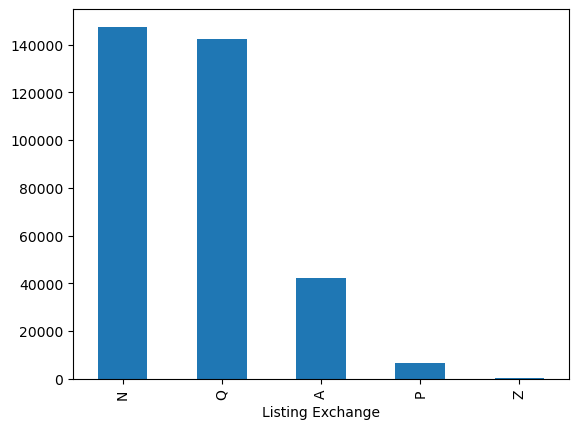

In [18]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [19]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['Listing Exchange']])

OneHotEncoder()

In [20]:
listing_enc = onehot.transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [22]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [23]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [24]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [25]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [26]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5657599339396241,
 'accuracy_score_test': 0.5684415412064822,
 'cohen_kappa_train': np.float64(0.0),
 'cohen_kappa_test': np.float64(0.0),
 'log_loss_train': 0.681626048081057,
 'log_loss_test': 0.6806199840456343,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [27]:
from sklearn.compose import ColumnTransformer

In [28]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [29]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [30]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [31]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6700571052588472,
 'log_loss_test': 0.670670278362559,
 'cohen_kappa_train': np.float64(0.001173973536641948),
 'cohen_kappa_test': np.float64(0.0013708729725581126),
 'f1_score_train': 0.002983621820644124,
 'f1_score_test': 0.003060964203724173,
 'accuracy_score_train': 0.5657679493855207,
 'accuracy_score_test': 0.5677738046964279}

In [32]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6225736112954785,
 'log_loss_test': 1.4806356066162913,
 'cohen_kappa_train': np.float64(0.17462172073016635),
 'cohen_kappa_test': np.float64(0.07841903344836187),
 'f1_score_train': 0.47960160188227263,
 'f1_score_test': 0.41780453188469635,
 'accuracy_score_train': 0.6065903885942316,
 'accuracy_score_test': 0.561470122018653}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [33]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [34]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.066113,0.087272,0.553917,0.601990,0.444612,0.486939,0.483258,0.552173,0.411689,0.435490,0.552043,0.653516,-2.695841,-0.626532,-0.272479,-0.222161
1,1.117497,0.095751,0.563944,0.601238,0.296575,0.444111,0.493704,0.561592,0.211947,0.367279,0.582135,0.650068,-1.854995,-0.628035,-0.257802,-0.222994
2,1.035285,0.091172,0.511509,0.615235,0.464520,0.504425,0.442750,0.571406,0.488542,0.451500,0.511371,0.670943,-1.601006,-0.618636,-0.268296,-0.218764
3,1.080994,0.088145,0.558415,0.603461,0.341202,0.455368,0.483328,0.563126,0.263668,0.382227,0.565601,0.651846,-1.628014,-0.626719,-0.257699,-0.222435
4,1.061158,0.098225,0.557995,0.602500,0.448269,0.483446,0.488702,0.553904,0.414015,0.428891,0.570402,0.652709,-1.859443,-0.625899,-0.258685,-0.222106


In [35]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.087898,0.087680,0.553799,0.602042,0.444995,0.487225,0.483134,0.552198,0.412437,0.435932,0.551859,0.653591,-2.707560,-0.626529,-0.272797,-0.222154
1,1.107601,0.087907,0.563811,0.601264,0.297347,0.444481,0.493379,0.561544,0.212797,0.367806,0.581831,0.650121,-1.862333,-0.628019,-0.257969,-0.222988
2,1.032975,0.090579,0.511479,0.615217,0.464384,0.504470,0.442698,0.571356,0.488304,0.451602,0.511312,0.670891,-1.607099,-0.618666,-0.268368,-0.218781
3,1.085424,0.088296,0.558518,0.603472,0.341138,0.455155,0.483531,0.563211,0.263532,0.381887,0.565182,0.651886,-1.644417,-0.626647,-0.257964,-0.222408
4,1.065276,0.098635,0.557686,0.602426,0.447343,0.482110,0.488256,0.554091,0.412757,0.426681,0.569719,0.652657,-1.924054,-0.625879,-0.259833,-0.222099


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [36]:
pd.DataFrame(d15_dict).mean()

fit_time                 1.075835
score_time               0.090619
test_accuracy            0.549059
train_accuracy           0.604884
test_f1                  0.399041
train_f1                 0.474688
test_precision           0.478199
train_precision          0.560480
test_recall              0.357965
train_recall             0.412782
test_roc_auc             0.555981
train_roc_auc            0.655829
test_neg_log_loss       -1.949093
train_neg_log_loss      -0.625148
test_neg_brier_score    -0.263386
train_neg_brier_score   -0.221686
dtype: float64